## <h1><center> Forecasting Models </center></h1>

This notebook consists of all the Models that are used to forecast the data using 'python'

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime as dt

In [160]:
# Load all avalible data

df_calandars = pd.read_csv('data/calendar_afcs2022.csv')
df_sales_train = pd.read_csv('data/sales_train_validation_afcs2022.csv')
df_sales_test = pd.read_csv('data/sales_test_validation_afcs2022.csv')
df_sample_sub = pd.read_csv('data/sample_submission_afcs2022.csv')
df_sell_prices = pd.read_csv('data/sell_prices_afcs2022.csv')

df_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Columns: 1914 entries, id to d_1913
dtypes: int64(1913), object(1)
memory usage: 12.0+ MB


In [161]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [162]:
timesteps = 14
startDay = 0
dt = downcast_dtypes(df_sales_train)

dt = dt.T
dt.head()


,0,1,2,3,4,5,6,7,8,9,...,813,814,815,816,817,818,819,820,821,822
id,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,FOODS_3_010_TX_3_validation,...,FOODS_3_818_TX_3_validation,FOODS_3_819_TX_3_validation,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation
d_1,0,0,0,0,0,0,27,0,0,0,...,0,9,3,0,7,0,0,0,0,0
d_2,2,0,0,0,1,0,27,0,0,0,...,0,0,2,0,5,0,1,0,0,0
d_3,1,0,0,0,1,0,8,0,0,0,...,0,3,1,0,5,0,0,0,0,0
d_4,3,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,0,1,2,0,0


In [163]:

dt = dt[1 + startDay:]
dt.head()

,0,1,2,3,4,5,6,7,8,9,...,813,814,815,816,817,818,819,820,821,822
d_1,0,0,0,0,0,0,27,0,0,0,...,0,9,3,0,7,0,0,0,0,0
d_2,2,0,0,0,1,0,27,0,0,0,...,0,0,2,0,5,0,1,0,0,0
d_3,1,0,0,0,1,0,8,0,0,0,...,0,3,1,0,5,0,0,0,0,0
d_4,3,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,0,1,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [164]:
daysBeforeEvent = pd.DataFrame(np.zeros((1969,1)))

for x,y in df_calandars.iterrows():
    if((pd.isnull(df_calandars["event_name_1"][x])) == False):
           daysBeforeEvent[0][x-1] = 1 

del df_calandars

daysBeforeEventTest = daysBeforeEvent[1913:1941]
daysBeforeEvent = daysBeforeEvent[startDay:1913]
daysBeforeEvent.columns = ["oneDayBeforeEvent"]
daysBeforeEvent.index = dt.index

dt = pd.concat([dt, daysBeforeEvent], axis = 1)
dt.columns


Index([                  0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,
       ...
                       814,                 815,                 816,
                       817,                 818,                 819,
                       820,                 821,                 822,
       'oneDayBeforeEvent'],
      dtype='object', length=824)

In [165]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dt_scaled = sc.fit_transform(dt)

X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(dt_scaled[i-timesteps:i])
    y_train.append(dt_scaled[i][0:823]) 

del dt_scaled

#Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)



/home/barath/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/barath/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(1899, 14, 824)
(1899, 823)


In [166]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

regressor = Sequential()
layer_1_units=50
regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
layer_2_units=400
regressor.add(LSTM(units = layer_2_units, return_sequences = True))
regressor.add(Dropout(0.2))
layer_3_units=400
regressor.add(LSTM(units = layer_3_units))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 823))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
epoch_no=50
batch_size=32
regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size)

Epoch 1/50


KeyboardInterrupt: 

In [119]:
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 14, 50)            175000    
                                                                 
 dropout_18 (Dropout)        (None, 14, 50)            0         
                                                                 
 lstm_20 (LSTM)              (None, 14, 400)           721600    
                                                                 
 dropout_19 (Dropout)        (None, 14, 400)           0         
                                                                 
 lstm_21 (LSTM)              (None, 400)               1281600   
                                                                 
 dropout_20 (Dropout)        (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 823)              

In [120]:
print(X_train.shape[1], X_train.shape[2])
inputs= dt[-timesteps:]
inputs = sc.transform(inputs)

X_test = []
X_test.append(inputs[0:timesteps])
X_test = np.array(X_test)
predictions = []

for j in range(timesteps,timesteps + 28):
    predicted_stock_price = regressor.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 824))
    testInput = np.column_stack((np.array(predicted_stock_price), daysBeforeEventTest[0][1913 + j - timesteps]))
    X_test = np.append(X_test, testInput).reshape(1,j + 1,824)
    predicted_stock_price = sc.inverse_transform(testInput)[:,0:823]
    predictions.append(predicted_stock_price)

idColumn = df_sample_sub[["id"]]
output_df = pd.DataFrame(data=np.array(predictions).reshape(28,823)).T
output_df = pd.concat([idColumn, output_df], axis=1) 
output_df.columns = df_sample_sub.columns
output_df.to_csv("output/lstm_performance.csv", index=False)
print(output_df)


14 824
1/1 [==============================] - 0s 20ms/step


/home/barath/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
                              id        F1        F2        F3        F4  \
0    FOODS_3_001_TX_3_validation  0.665552  0.607846  0.572837  0.539816   
1    FOODS_3_002_TX_3_validation  0.925522  0.979213  1.022714  1.050865   
2    FOODS_3_003_TX_3_validation  0.504115  0.471037  0.433213  0.416612   
3    FOODS_3_004_TX_3_validation  0.178915  0.179626  0.176248  0.170834   
4    FOODS_3_005_TX_3_validation  1.155087  1.068102  1.004491  0.955353   
..                           ...       ...       ...       ...       ...   
818  FOODS_3_823_TX_3_validation  0.522759  0.489522  0.468331  0.449465   
819  FOODS_3_824_TX_3_validation  0.039159  0.057392  0.061113  0.065979   
820  FOODS_3_825_TX_3_validation  1.150083  1.115617  1.047227  1.034021   
821  FOODS_3_826_TX_3_validation  1.364954  1.262032  1.211407  1.178939   
822  FOODS_3_827_TX_3_validation  0.757748  0.705051  0.681211  0.688998   

           F5        F6        F7  

<AxesSubplot: title={'center': 'Train Sales from the Data'}>

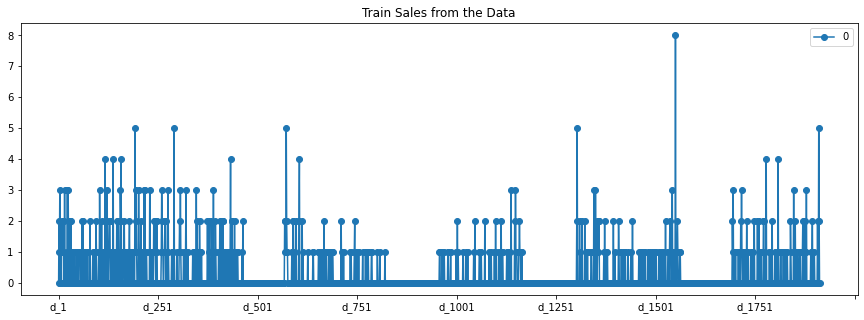

In [158]:
# Plot using
# 1-1915 Val for a Random Item - Train
# 1916-

fig,axs = plt.subplots(figsize=(15,5))
d_cols = [c for c in df_sales_train.columns if 'd_' in c]
df_sales_train[df_sales_train['id'] == 'FOODS_3_001_TX_3_validation'][d_cols].T.plot(ax=axs, title="Train Sales from the Data", linestyle='-', marker='o')


<AxesSubplot: title={'center': 'Next 28 Day forecast for a Random ID using LSTM'}>

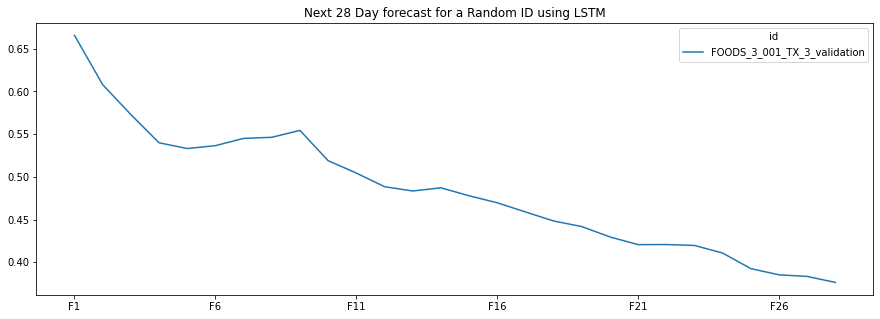

In [156]:
fig,axs = plt.subplots(figsize=(15,5))
d_cols = [c for c in df_sales_train.columns if 'd_' in c]
output_df[output_df['id'] == 'FOODS_3_001_TX_3_validation'].set_index('id').T.plot(ax=axs, title="Next 28 Day forecast for a Random ID using LSTM")